In [1]:
start_date = "2023-01-01"

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import urllib

import datetime
import math

import matplotlib.pyplot as pl
import matplotlib.ticker as ticker

In [3]:
sql = F"""
select
  strftime('%Y',entry_date) as year,
  strftime('%W',entry_date)+1 as week,
  status,
  count(*) as count
from log
where entry_date >= '{start_date}'
 group by year, week, status
"""

In [4]:
datasette_url = "https://datasette.planning.data.gov.uk/"

params = urllib.parse.urlencode({
"sql": sql,
"_size": "max"
})

url = f"{datasette_url}digital-land.csv?{params}"
df = pd.read_csv(url, dtype={'status': str})

In [5]:
df["result"] = df["status"].apply(lambda status: "OK" if status == "200" else "Error")

In [6]:
df = df.pivot_table(index=["year", "week"], columns="result", values="count", aggfunc=np.sum, fill_value=0)

In [7]:
df["total"] = df["Error"] + df["OK"]
df["ratio"] = 100 * df["Error"] / df["total"]

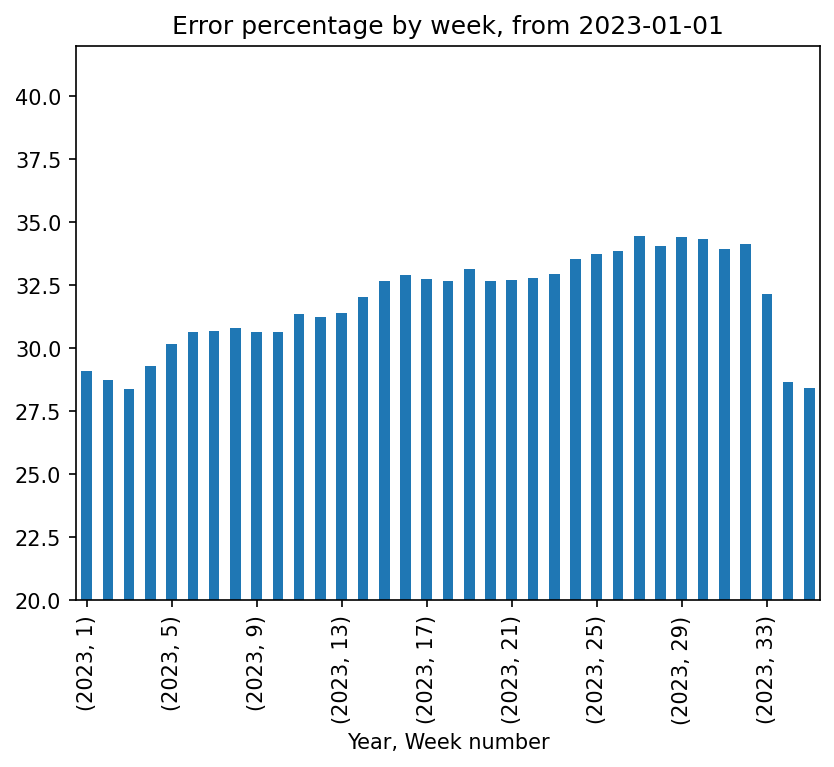

In [8]:
ymin = 4 * int((min(df["ratio"])) / 5) 
ymax = 6 * (math.ceil(max(df["ratio"])) / 5) 

pl.rcParams['figure.dpi'] = 150

ax = df.plot.bar(y="ratio" )

ax.set_title(F"Error percentage by week, from {start_date}")


ax.get_legend().remove()
ax.set_ylabel(None)
ax.set_ylim(ymin, ymax)

ax.set_xlabel("Year, Week number")
xlocator = ticker.MaxNLocator (9) #(min(6,int(df.shape[0]/8)))
ax.xaxis.set_major_locator(xlocator)
